In [1]:
from ultralytics import YOLO

import matplotlib.pyplot as plt
from PIL import Image
import cv2

import numpy as np
import torch
import json
import easyocr

import time
import os
import gc
import math
import re

from sklearn.cluster import DBSCAN
from collections import defaultdict, Counter

In [2]:
reader = easyocr.Reader(
    lang_list=['en'],
    gpu=False,
    model_storage_directory="model/"
)

Using CPU. Note: This module is much faster with a GPU.


In [3]:
yolo = YOLO("model/yolo-obb.pt")

In [4]:
map_resources = {} 
# path = "/kaggle/input/real-estate"
path = "."
with open(f"{path}/data/mapping.json", "r", encoding="utf-8") as f:
    map_resources["mapping"] = json.load(f)

with open(f"{path}/data/metadata.json", "r", encoding="utf-8") as f:
    map_resources["metadata"] = json.load(f)
    
map_resources["image"] = cv2.cvtColor(cv2.imread(f"{path}/data/map.JPG"), cv2.COLOR_BGR2RGB) 

In [5]:
root_dir = f"{path}/data/design/"
resources = {}

for apartment in os.listdir(root_dir):
    apt_path = os.path.join(root_dir, apartment)
    if not os.path.isdir(apt_path):
        continue

    resources[apartment] = {}
    for floor in os.listdir(apt_path):
        floor_path = os.path.join(apt_path, floor)
        if not os.path.isdir(floor_path):
            continue

        res = {}
        mapping_file = os.path.join(floor_path, "mapping.json")
        if os.path.exists(mapping_file):
            with open(mapping_file, "r", encoding="utf-8") as f:
                res["mapping"] = json.load(f)

        metadata_file = os.path.join(floor_path, "metadata.json")
        if os.path.exists(metadata_file):
            with open(metadata_file, "r", encoding="utf-8") as f:
                res["metadata"] = json.load(f)

        map_file = os.path.join(floor_path, "design.jpg")
        if os.path.exists(map_file):
            res["image"] = cv2.cvtColor(cv2.imread(map_file), cv2.COLOR_BGR2RGB) 

        resources[apartment][floor] = res

In [6]:
def crop_from_original(resources, code, padding=0):
    tiles_list = resources["mapping"][code]
    offsets = resources["metadata"]
    min_x, min_y = float("inf"), float("inf")
    max_x, max_y = 0, 0

    for tile_name in tiles_list:
        off = offsets[tile_name]
        x, y, w, h = off["x"], off["y"], off["width"], off["height"]

        min_x = min(min_x, x) + padding
        min_y = min(min_y, y) + padding
        max_x = max(max_x, x + w) + padding
        max_y = max(max_y, y + h) + padding

    cropped = resources["image"][min_y:max_y, min_x:max_x]
    return cropped

In [7]:
def bbox_overlap(b1, b2, axis='y', margin=0):
    if axis == 'x':
        return not (b1[1][0]+margin < b2[0][0] or b2[1][0]+margin < b1[0][0])
    else:
        return not (b1[2][1]+margin < b2[0][1] or b2[2][1]+margin < b1[0][1])
            
def crop_building(img, building_code):
    results = reader.readtext(img)
    results_sorted = sorted(results, key=lambda x: x[0][0][0])
    results_sorted = [(bbox, text.replace(",", ".")) for (bbox, text,_) in results_sorted]
    results_sorted = [
        (bbox, text.replace("5", "S") if "." in text else text)
        for bbox, text in results_sorted
    ]

    for bbox, text in results_sorted:
        if text == building_code:
            print("có trong mảng ocr")
            return (bbox, text)

    chosen_results = []
    matched_chars = {}
    code_chars = list(building_code)
    candidate_bboxes = results_sorted.copy()
    
    for last_index, char in enumerate(code_chars):
        next_candidates, tmp = [], []
        for bbox, text in candidate_bboxes:
            if char in text:
                tmp.append((text, bbox))
                next_candidates.append((bbox, text))
                
        if not tmp:
            break
        matched_chars[last_index] = tmp
        candidate_bboxes = next_candidates

    last_matches = matched_chars.get(last_index-1, [])
    chosen_results = None

    for text1, bbox1 in last_matches:
        overlap = next(
            ((other_text, other_bbox) for other_bbox, other_text in results_sorted
             if other_bbox != bbox1 
             and bbox_overlap(bbox1, other_bbox, axis='y') 
             and other_text == building_code[last_index:]),
            None
        )
        if overlap:
            text2, bbox2 = overlap
            merged_text = text1 + text2
            all_x = [pt[0] for pt in bbox1 + bbox2]
            all_y = [pt[1] for pt in bbox1 + bbox2]
            merged_bbox = [
                [min(all_x), min(all_y)],
                [max(all_x), min(all_y)],
                [max(all_x), max(all_y)],
                [min(all_x), max(all_y)]
            ]
            chosen_results = (merged_bbox, merged_text)
    return chosen_results

In [8]:
def crop_building_region(img_resized, chosen_results, building_code,
                         TOP_RATIO=0.25, BOTTOM_RATIO=0.30, SIDE_RATIO=0.25):
    h_img, w_img = img_resized.shape[:2]
    bbox, text = chosen_results
    clean_text = text.upper().replace("O", "0").replace(",", ".").replace(" ", "")
    if clean_text == building_code:
        (x_min, y_min) = bbox[0]
        (x_max, y_max) = bbox[2]

        expand_top = int(TOP_RATIO * h_img)
        expand_bottom = int(BOTTOM_RATIO * h_img)
        expand_side = int(SIDE_RATIO * w_img)

        x_min = max(0, int(x_min - expand_side))
        y_min = max(0, int(y_min - expand_top))
        x_max = min(w_img, int(x_max + expand_side))
        y_max = min(h_img, int(y_max + expand_bottom))

        img_cropped = img_resized[y_min:y_max, x_min:x_max]

        return img_cropped

    print(f"⚠️ Không tìm thấy building_code: {building_code}")
    return None

### Explore design drawings

In [ ]:
def merge_row_into_existing(rows, new_row):
    if not rows:
        return [new_row]

    merged = False
    for i, existing in enumerate(rows):
        if set(existing) & set(new_row):
            combined = sorted(set(existing + new_row),
                              key=lambda x: int(x[2:]))
            rows[i] = combined
            merged = True
            break

    if not merged:
        rows.append(new_row)

    return rows


def find_apartment_rows(reader, floor_resources, max_num, y_threshold=30):
    rows = []
    index = 1

    while index <= max_num:
        target_key = f"CH{index:02d}"
        design_cropped = crop_from_original(floor_resources, f'CH{index:02d}')

        results = reader.readtext(design_cropped)
        filtered_results = []
        pattern = re.compile(r"^CH\d{2}$")

        for bbox, text, conf in results:
            clean_text = text.strip().upper()
            clean_text = (clean_text.replace("O", "0").replace("S", "5")
                                    .replace("I", "1").replace("L", "1")
                                    .replace("B", "8").replace("T", "1"))
            if pattern.match(clean_text):
                filtered_results.append((bbox, clean_text))

        if not filtered_results:
            index += 1
            continue

        centers = {text: sum(p[1] for p in bbox) / len(bbox) for bbox, text in filtered_results}

        if target_key in centers:
            apartments = [name for name, cy in centers.items() if abs(cy - centers[target_key]) < y_threshold]
            apartments.sort()
        else:
            apartments = []

        print(f"{target_key} -> {apartments}")
        if apartments:
            rows = merge_row_into_existing(rows, apartments)
            last_apartment = max(int(a[2:]) for a in apartments)
            index = last_apartment + 1
        else:
            rows = merge_row_into_existing(rows, [target_key])
            index += 1
            
    return rows

In [ ]:
# building_code="S6.06"
# floor_number=20
# floor_ranges = resources[building_code.replace(".", "")].keys()
# for i, fr in enumerate(floor_ranges):
#     try:
#         _, start, end = fr.split("_")
#         start, end = int(start), int(end)
#         if start <= floor_number <= end:
#             floor = fr
#             break
#     except ValueError:
#             continue
        
# floor_resources = resources[building_code.replace(".", "")][floor]
# n_apartments = len(floor_resources["mapping"].keys())
# print(n_apartments)
# rows = find_apartment_rows(
#     reader, floor_resources,
#     max_num=n_apartments,
#     y_threshold=30
# )

### Explore map

(2294, 2314, 3)
(918, 926, 3)


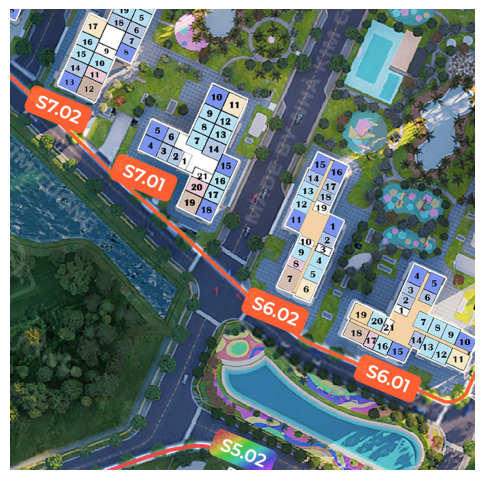

In [11]:
building_code="S6.01"
map_cropped = crop_from_original(map_resources, building_code, padding=10)
print(map_cropped.shape)

h, w = map_cropped.shape[:2]
margin_ratio = 0.3
dx = int(w * margin_ratio)
dy = int(h * margin_ratio)
img_resized = map_cropped[dy:h - dy, dx:w - dx]
print(img_resized.shape)

plt.figure(figsize=(6, 6))
plt.imshow(img_resized)
plt.axis("off")
plt.show()

có trong mảng ocr


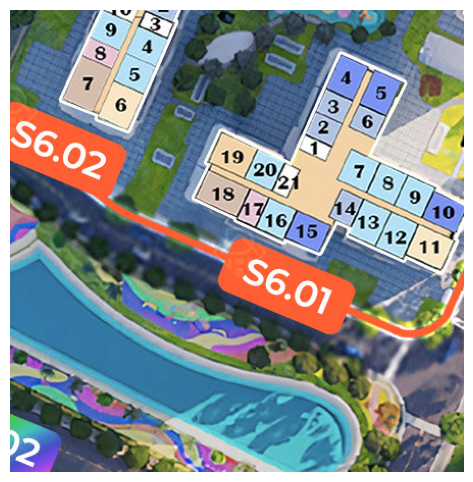

In [12]:
chosen_bbox = crop_building(img_resized, building_code)
img_cropped = crop_building_region(img_resized, chosen_bbox, building_code=building_code)
plt.figure(figsize=(6,6))
plt.imshow(img_cropped)
plt.axis("off")
plt.show()

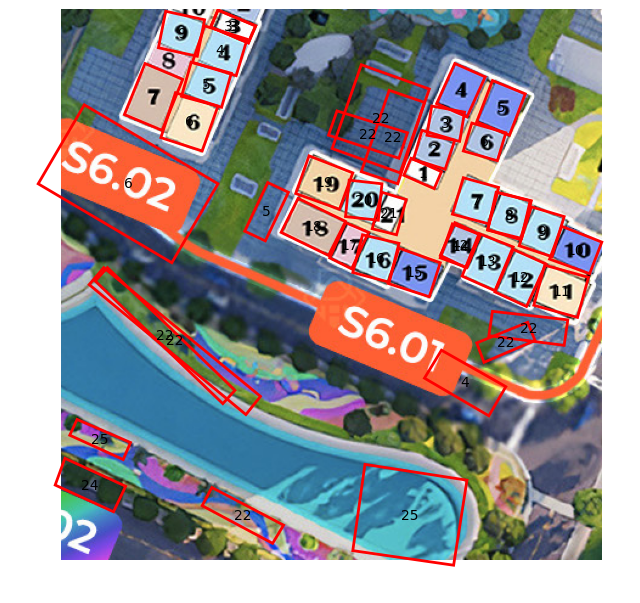

In [13]:
yolo_results = yolo.predict(
    source=img_cropped,
    conf=0.4,
    imgsz=640,
    show=False, 
    verbose=False
)

obb_array = yolo_results[0].obb.xyxyxyxyn.cpu().numpy()
class_ids = yolo_results[0].obb.cls.cpu().numpy().astype(int)

img_vis = img_cropped.copy()
h, w = img_vis.shape[:2]
plt.figure(figsize=(8,8))
plt.imshow(img_vis)
plt.axis('off')

for obb, cls_id in zip(obb_array, class_ids):
    coords = obb.reshape(4,2).copy() 
    coords[:,0] *= w
    coords[:,1] *= h
    tmp = coords.astype(np.int32)
    plt.fill(tmp[:,0], tmp[:,1], edgecolor='red', fill=False, linewidth=2)
    cx, cy = tmp[:,0].mean(), tmp[:,1].mean()
    plt.text(cx, cy, str(cls_id + 1), color='black', fontsize=10, ha='center', va='center')

plt.show()